In [2]:
import dask.dataframe as dd
import datetime
from collections import defaultdict
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#hierarchical clustering
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
#Kmeans and PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#### df_cat = pd.read_csv('kmeans_category_3.csv',index_col='Category') 
df_stores = pd.read_csv('df_stores_for_clustering.csv',index_col='store')
df_matrix = pd.read_csv('store_cat_matrix.csv')

In [4]:
df_cat.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
df_cat = df_cat[['labels']]

In [6]:
df_cat.head(2)

,labels
Category,
1,3
2,3


In [7]:
df_stores.head(2)

,u_TY,v_TY,u%vsLY,uLY%vsLLY,v%vsLY,vLY%vsLLY,avg_price
store,,,,,,,
1,137834.0,2.353339e+08,0.135916,-0.212368,0.185746,-0.183937,1707.372162
2,88077.0,1.507813e+08,0.138519,-0.203376,0.180182,-0.178906,1711.925901


In [8]:
df_matrix.head(2)

,store,Category,u_16,v_16,u_17,v_17,u_18,v_18,u_19,v_19
0,1,1,1224.0,9.113103e+05,1127.0,870791.0,1299.0,1018369.0,911.0,727387.0
1,1,2,2434.0,1.707717e+06,2390.0,1635066.0,2675.0,1918203.0,2468.0,1809419.0


In [9]:
df_matrix.reset_index(inplace = True)
df_matrix.drop('index', axis=1, inplace = True)

In [10]:
concat = df_matrix.merge(df_cat, left_on = 'Category', right_index = True)

In [11]:
group = pd.pivot_table(concat, values=['u_19','v_19'], index=['store'], columns =['labels'], aggfunc=([np.sum]))

group.columns = group.columns.droplevel(0)

In [12]:
group

u_19                                v_19                              \
labels     0         1       2        3        0             1             2   
store                                                                          
1       31.0  116547.0  2512.0  18736.0  43660.0  2.148653e+08  5.214266e+06   
2       13.0   76183.0   705.0  11175.0  21954.0  1.404033e+08  1.447222e+06   
3       10.0  122901.0  1333.0  14001.0  15424.0  2.428049e+08  2.673512e+06   
4       49.0  157394.0  5244.0  22580.0  94899.0  2.770156e+08  1.033232e+07   
5       12.0   85818.0  1185.0  12022.0  17860.0  1.488500e+08  2.303642e+06   
...      ...       ...     ...      ...      ...           ...           ...   
406     17.0   99451.0  1590.0  12803.0  21298.0  1.756291e+08  2.451813e+06   
407     37.0  160655.5  3562.0  22146.5  41223.0  2.844171e+08  5.918626e+06   
408     32.0   93221.5  1466.0  13444.0  26552.0  1.600666e+08  2.609102e+06   
409     43.0   90520.0  1334.0  10811.0   3805.0  1.605963e+08  2.327859e+06   
410     65.0  164743.0  6093.0  24299.0  92523.0  2.872168e+08  1.151155e+07   

                      
labels             3  
store                 
1       1.520268e+07  
2       8.907882e+06  
3       1.133094e+07  
4       1.709296e+07  
5       9.156329e+06  
...              ...  
406     9.115189e+06  
407     1.710771e+07  
408     1.060948e+07  
409     7.992615e+06  
410     1.737780e+07  

[410 rows x 8 columns]

In [13]:
group.columns

MultiIndex([('u_19', 0),
            ('u_19', 1),
            ('u_19', 2),
            ('u_19', 3),
            ('v_19', 0),
            ('v_19', 1),
            ('v_19', 2),
            ('v_19', 3)],
           names=[None, 'labels'])

In [14]:
group.columns = [('u19_0'),('u19_1'),('u19_2'),('u19_3'),('v19_0'),('v19_1'),('v19_2'),('v19_3')]

In [15]:
res = group[['u19_0','u19_1','u19_2','u19_3']].div(group[['u19_0','u19_1','u19_2','u19_3']].sum(axis=1), axis=0)
group = group.merge(res, right_index = True, left_index = True)

In [16]:
group.columns = ['u_0', 'u_1', 'u_2', 'u_3', 'v_0', 'v_1','v_2', 'v_3','u_0p', 'u_1p', 'u_2p', 'u_3p']

In [17]:
df = group.merge(df_stores, right_index = True, left_index = True)

In [18]:
df.head(2)

,u_0,u_1,u_2,u_3,v_0,v_1,v_2,v_3,u_0p,u_1p,u_2p,u_3p,u_TY,v_TY,u%vsLY,uLY%vsLLY,v%vsLY,vLY%vsLLY,avg_price
store,,,,,,,,,,,,,,,,,,,
1,31.0,116547.0,2512.0,18736.0,43660.0,2.148653e+08,5214266.0,1.520268e+07,0.000225,0.845610,0.018226,0.135940,137834.0,2.353339e+08,0.135916,-0.212368,0.185746,-0.183937,1707.372162
2,13.0,76183.0,705.0,11175.0,21954.0,1.404033e+08,1447222.0,8.907882e+06,0.000148,0.864969,0.008004,0.126879,88077.0,1.507813e+08,0.138519,-0.203376,0.180182,-0.178906,1711.925901


In [19]:
df['avg_0'] = df['v_0']/df['u_0']
df['avg_1'] = df['v_1']/df['u_1']
df['avg_2'] = df['v_2']/df['u_2']
df['avg_3'] = df['v_3']/df['u_3']

In [20]:
df.drop(columns = ['v_0', 'v_1','v_2', 'v_3'], inplace = True)

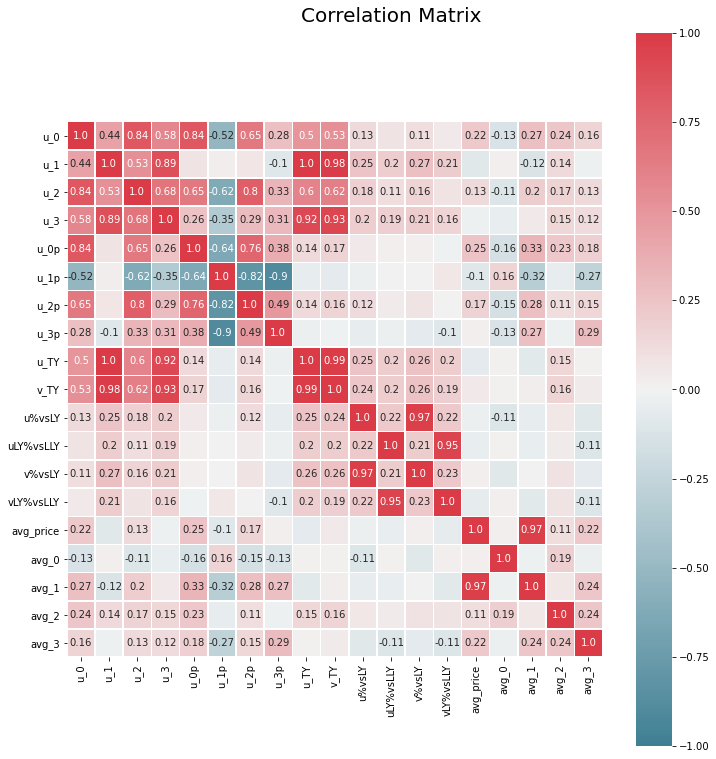

In [21]:
fig = plt.figure(figsize=(12, 12))
# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.4| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.1
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) 

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [22]:
df = df.loc[:, ~df.columns.str.startswith('v')]

In [23]:
df = df.fillna(0)

In [24]:
df.drop('uLY%vsLLY', axis=1, inplace = True)

In [25]:
df_og = df.copy()

In [26]:
scaler = StandardScaler()
df.iloc[:,:] = scaler.fit_transform(df.iloc[:,:].to_numpy())

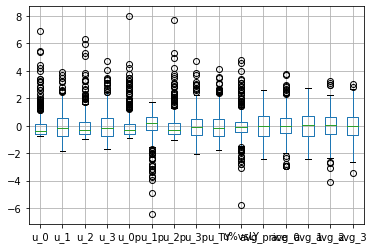

In [27]:
boxplot = df.boxplot()

In [28]:
df_copy = df.copy()

df.drop(columns = ['avg_0', 'avg_1', 'avg_2','avg_3'], inplace = True)

In [29]:
df = df[['u_0p', 'u_1p', 'u_2p', 'u_3p']]

In [30]:
def get_r2_hc(df, link, max_nclus, min_nclus=1, dist="euclidean"):

    def get_ss(matrix):
        mc = matrix - matrix.mean(axis=0)
        return (mc.T@mc).trace() #return sum of squares of matrix
    
    matrix = df.values
    ncols = matrix.shape[1]
    sst = get_ss(matrix) #get total sum of squares
    
    r2 = np.array([]) #where we will store the R2 metrics
    
    for i in range(min_nclus, max_nclus+1):
        Hclustering = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link)
        hclabels = Hclustering.fit_predict(matrix) #get cluster labels
        concat = np.concatenate((matrix, np.expand_dims(hclabels,1)), axis=1)
        ssw = np.array([get_ss(concat[concat[:,ncols]==j, :ncols]) for j in range(i)]).sum() #calculate ssw for a given cluster solution
        r2 = np.append(r2, (sst-ssw)/sst) #save the R2 of the given cluster solution
        
    return r2

In [31]:
number_clusters = 100
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df)

In [32]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km_labels, name='labels')), axis=1)
aa = df_concat.groupby('labels').mean()

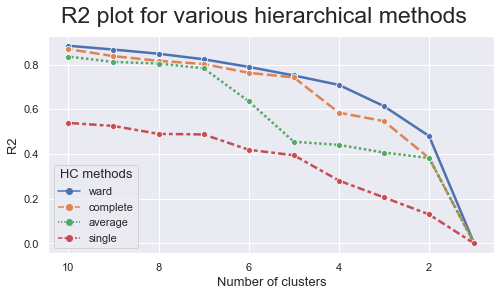

In [33]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Function defined above to obtain the R2 statistic
r2_hc_methods = pd.DataFrame(data=np.concatenate([np.expand_dims(get_r2_hc(df=aa, link=i, max_nclus=10), 1) for i in hc_methods], axis=1),
                             index=range(1,10+1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(8,4))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=23)
plt.gca().invert_xaxis()
plt.legend(title="HC methods", title_fontsize=13)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2", fontsize=13)

plt.show()

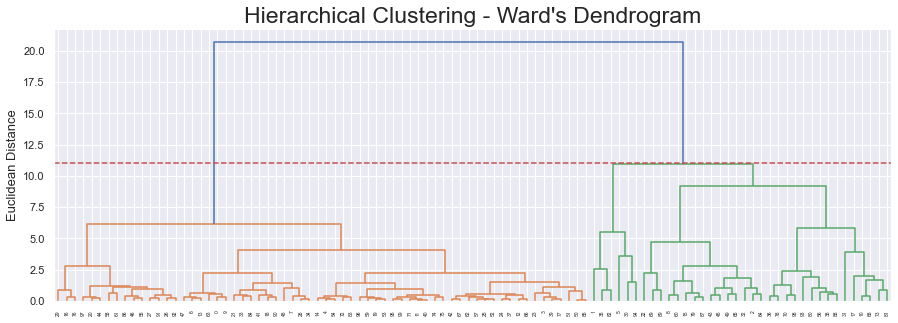

In [34]:
# Hierarchical clustering assessment using scipy
#looking at the graph above we will use the ward method
Z = linkage(aa, method="ward")

sns.set()
fig = plt.figure(figsize=(15,5))

# Dendrogram

dendrogram(Z)

plt.hlines(11, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering - Ward\'s Dendrogram', fontsize=23)
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

In [35]:
range_clusters = range(1, 20)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df)
    inertia.append(kmclust.inertia_)  

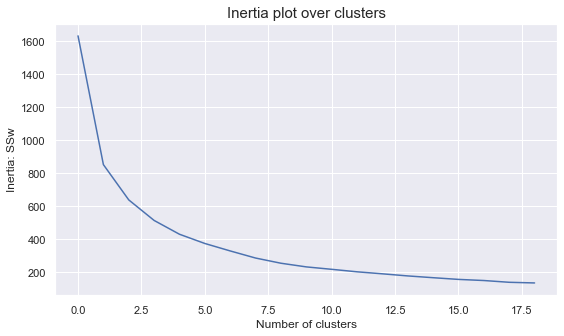

In [36]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [37]:
# final cluster solution. x clusters was chosen looking at ward dendogram
number_clusters = 5

kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df)

In [38]:
df_reset = df_og.reset_index()

df_concat = pd.concat((df_reset, pd.Series(km_labels, name='labels')), axis=1)
dataset = df_concat.groupby('labels').mean().round(3)

dataset

,store,u_0,u_1,u_2,u_3,u_0p,u_1p,u_2p,u_3p,u_TY,u%vsLY,avg_price,avg_0,avg_1,avg_2,avg_3
labels,,,,,,,,,,,,,,,,
0,233.333,158.030,103053.470,5676.697,17426.318,0.001,0.815,0.044,0.140,126320.667,0.156,1753.510,1320.705,1901.319,2075.613,794.101
1,163.396,24.481,92437.380,1678.807,12131.746,0.000,0.871,0.015,0.114,106272.971,0.152,1683.968,1545.973,1797.009,2004.881,778.396
2,292.500,243.375,86931.000,11602.750,22432.875,0.002,0.709,0.101,0.188,121213.875,0.163,1770.607,1262.052,1993.204,2029.409,809.648
3,227.848,37.715,97725.949,2275.804,16440.687,0.000,0.839,0.019,0.142,116481.503,0.152,1687.396,1614.402,1833.292,2024.139,783.071
4,339.409,66.227,76973.295,5005.136,18339.045,0.001,0.765,0.050,0.184,100387.068,0.157,1682.718,1290.525,1870.372,2014.694,816.747


In [39]:
unique, counts = np.unique(km_labels, return_counts=True)
dict(zip(unique, counts))

{0: 33, 1: 187, 2: 8, 3: 158, 4: 22}

In [40]:
feats = df.columns.to_list()

In [41]:
feats_2 = feats.copy()

In [42]:
feats_2.append('labels')

In [43]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return(ss)

sst = get_ss(df_concat[feats])  # get total sum of squares
ssw_labels = (df_concat[feats_2]).groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
adj=1-((1-r2)*(10000-1)/(10000-len(feats)-1))
adj.round(2)

0.78